In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import seawater as sw
import gsw
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [5]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
#cluster = PBSCluster(local_directory=local_dir)
cluster = PBSCluster(cores=8, processes=1,memory='20GB')
#cluster = PBSCluster(cores=4, processes=2, memory='50 G', resource_spec='select=1:ncpus=28:mem=110GB') 
#print(cluster.job_script())
w = cluster.start_workers(5)

TypeError: can only concatenate str (not "list") to str

In [6]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

NameError: name 'cluster' is not defined

In [4]:
client

Client Scheduler: tcp://10.148.0.219:45442 Dashboard: http://10.148.0.219:8787/status,Cluster Workers: 34 Cores: 136 Memory: 1700.00 GB


_________
# 1. Read dataset


In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_D = xr.open_zarr(out_dir_zarr+'Pden_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

# buoyancy
ds_B = -9.81*(ds_D.Pden-25)/1025
ds_B = np.real(ds_B).rename('Buoy')
ds_B = ds_B.to_dataset()

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_D,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})
print(ds)

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 ...
  * depth       (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
  * time        (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 ...
  * lon         (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ..

In [6]:
grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)

ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl_total_rechunk.zarr')
ds_Eta = xr.open_zarr(out_dir_zarr+'Eta_total_rechunk.zarr')
ds_taux = xr.open_zarr(out_dir_zarr+'oceTAUX_total_rechunk.zarr')
ds_tauy = xr.open_zarr(out_dir_zarr+'oceTAUY_total_rechunk.zarr')
ds_fwflx = xr.open_zarr(out_dir_zarr+'oceFWflx_total_rechunk.zarr')
ds_qnet = xr.open_zarr(out_dir_zarr+'oceQnet_total_rechunk.zarr')
ds_qsw = xr.open_zarr(out_dir_zarr+'oceQsw_total_rechunk.zarr')
ds_sflux = xr.open_zarr(out_dir_zarr+'oceSflux_total_rechunk.zarr')

ds_surface = xr.merge([ds_KPP,ds_Eta,ds_taux,ds_tauy,ds_fwflx,ds_qnet,ds_qsw,ds_sflux,grid])

In [7]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon (177) --> left
  * left     lon_g (177) --> center
Y Axis (periodic):
  * center   lat (201) --> left
  * left     lat_g (201) --> center
Z Axis (not periodic):
  * center   depth (52) --> left
  * left     depth_left (52) --> center


In [8]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')
ds

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 ...
  * depth       (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
  * time        (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 ...
  * lon         (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ..

In [9]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')
f

<xarray.DataArray 'YG' (lat_g: 201, lon_g: 177)>
array([[0.000107, 0.000107, 0.000107, ..., 0.000107, 0.000107, 0.000107],
       [0.000107, 0.000107, 0.000107, ..., 0.000107, 0.000107, 0.000107],
       [0.000108, 0.000108, 0.000108, ..., 0.000108, 0.000108, 0.000108],
       ...,
       [0.000112, 0.000112, 0.000112, ..., 0.000112, 0.000112, 0.000112],
       [0.000112, 0.000112, 0.000112, ..., 0.000112, 0.000112, 0.000112],
       [0.000112, 0.000112, 0.000112, ..., 0.000112, 0.000112, 0.000112]],
      dtype=float32)
Coordinates:
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 -17.92 ...
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 47.49 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 47.39811 47.39811 47.39811 47.39811 ...
    rAz      (lat_g, lon_g) float32 ...

In [10]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)

ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_lowpass_filter_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_lowpass_filter_rechunk.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,grid])
ds_filter = generate_grid_ds(ds_filter, {'Z':'depth'})

print(ds_filter)

<xarray.Dataset>
Dimensions:       (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
    dxC           (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyG           (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dzt           (depth) float64 dask.array<shape=(52,), chunksize=(1,)>
  * lat           (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 ...
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 ...
    rAw           (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * time          (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 ...
    dxG           (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyC           (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * lat_g         (lat_g) float

# 2. Parameter

## 2.1 Rossby number

In [12]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta

<xarray.DataArray (lat_g: 201, lon_g: 177, time: 9415, depth: 52)>
dask.array<shape=(201, 177, 9415, 52), dtype=float32, chunksize=(1, 1, 9415, 1)>
Coordinates:
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 47.49 ...
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 -17.92 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 47.39811 47.39811 47.39811 47.39811 ...
    rAz      (lat_g, lon_g) float32 ...

In [11]:
zeta_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') - gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
zeta_filter

<xarray.DataArray (lat_g: 201, lon_g: 177, time: 9415, depth: 52)>
dask.array<shape=(201, 177, 9415, 52), dtype=float32, chunksize=(1, 1, 9415, 1)>
Coordinates:
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 47.49 ...
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 -17.92 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    rAz      (lat_g, lon_g) float32 ...

In [13]:
zeta_filter_f = (zeta_filter/f)

In [14]:
zeta_f = (zeta/f)

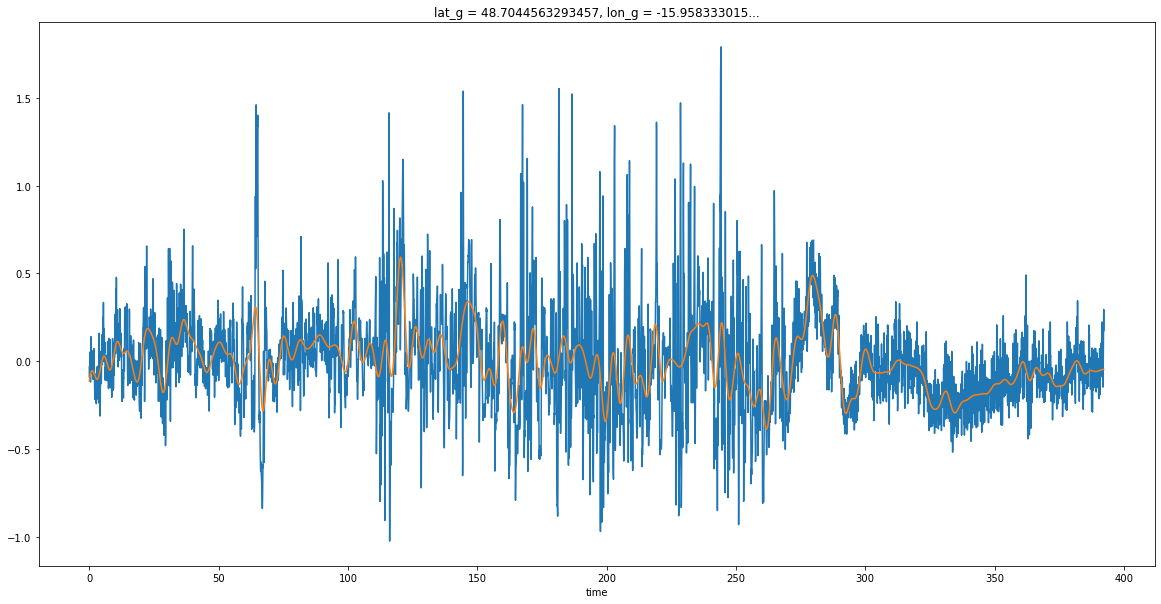

In [15]:
fig = plt.figure(figsize=(20,10))
zeta_f.isel(lat_g=100, lon_g=100,depth=1).plot()
zeta_filter_f.isel(lat_g=100, lon_g=100,depth=1).plot()

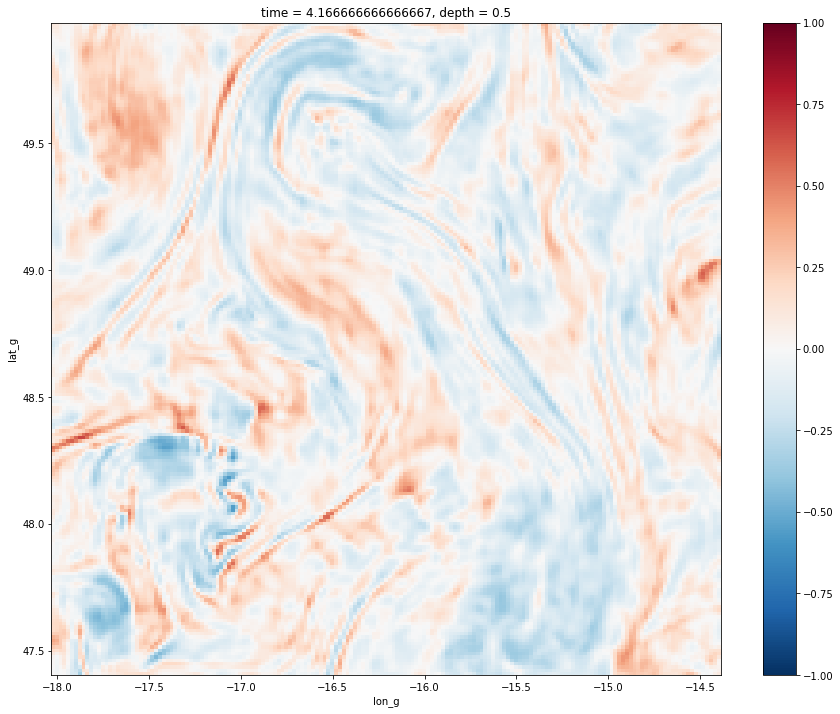

In [17]:
fig = plt.figure(figsize=(15,12))

zeta_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),time=100,depth=0).plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap='RdBu_r')

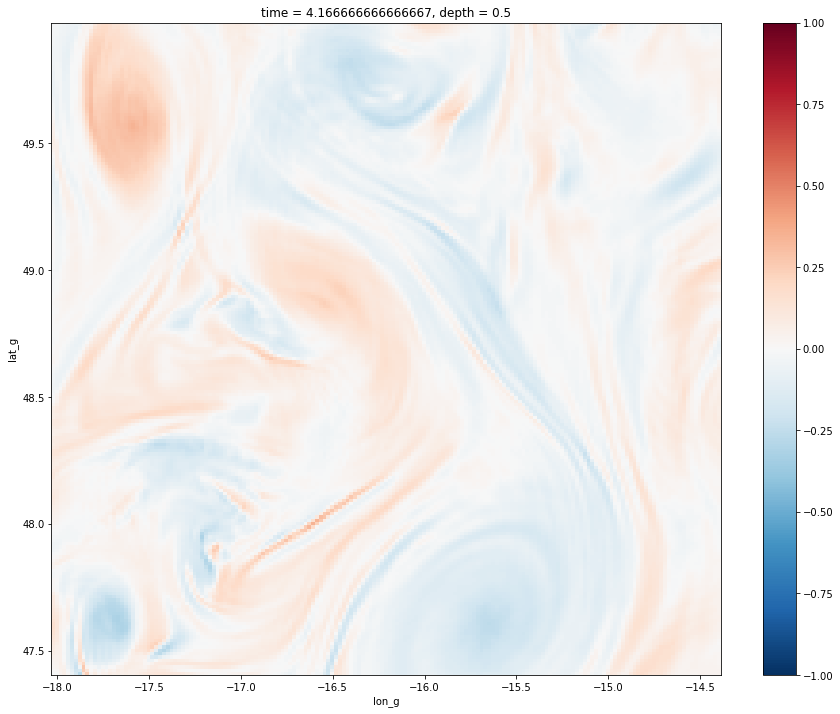

In [16]:
fig = plt.figure(figsize=(15,12))

zeta_filter_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),time=100,depth=0).plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap='RdBu_r')

## 2.2 KE

In [18]:
KE = (gridx.interp(ds['U']**2,'X') + gridx.interp(ds['V']**2,'Y'))/2 # KE
KE

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

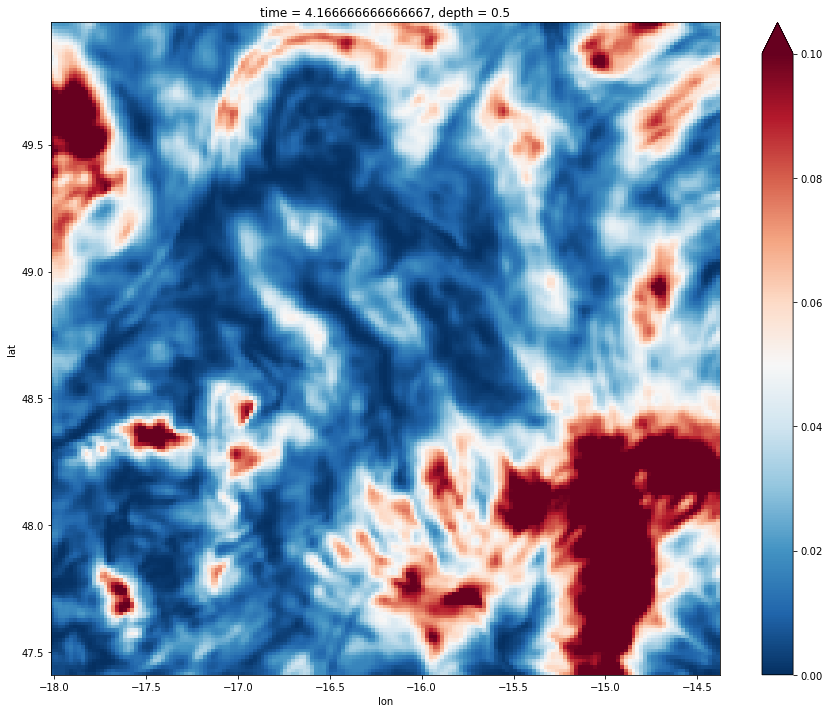

In [19]:
fig = plt.figure(figsize=(15,12))

KE.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=0, vmax=0.1, cmap='RdBu_r')

## 2.3 Horizontal strain

In [10]:
strain = (gridx.diff(ds['U'] * ds.dyG, 'X') - gridx.diff(ds['V']* ds.dxG, 'Y')) / ds.rA
strain

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    rA       (lat, lon) float32 ...

In [11]:
strain_f = (strain/f_ij)

In [13]:
store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
strain_f = strain_f.chunk(chunks)
strain_f = np.real(strain_f).rename('strain_f')
strain_f = strain_f.to_dataset()
print(strain_f)
file_out = store_dir_zarr+'/Strain_f_rechunk.zarr'
%time strain_f.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:   (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time      (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth     (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
  * lat       (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon       (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
    XC        (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    YC        (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    CS        (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    SN        (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    Depth     (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    rA        (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
Data variables:
    strain_f  (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 

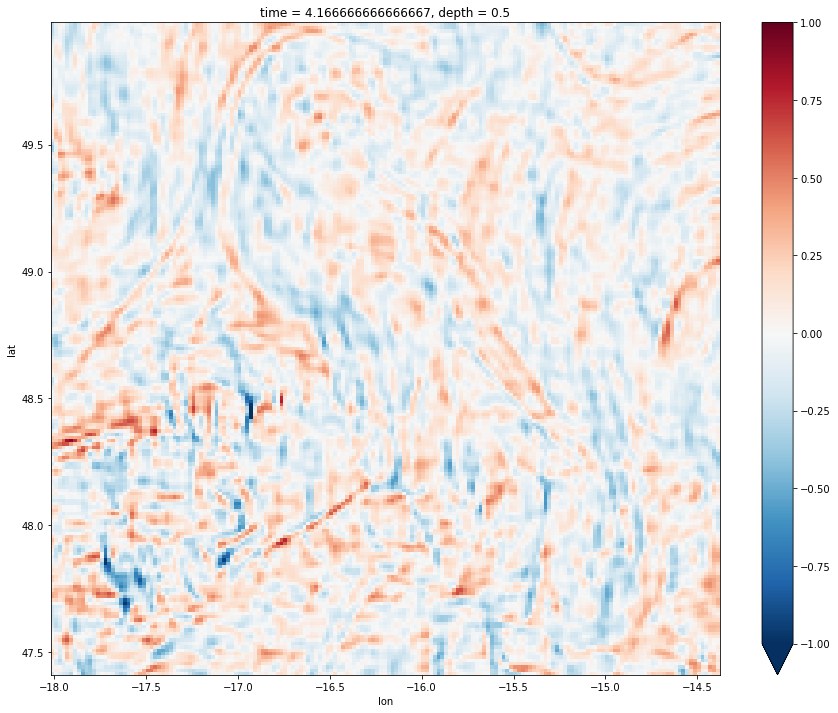

In [22]:
fig = plt.figure(figsize=(15,12))

strain_f.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap='RdBu_r')

## 2.4 lateral gradient

In [10]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')
db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

lateral_buoyancy_gradient = np.sqrt(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij)
print(lateral_buoyancy_gradient)

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 1)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


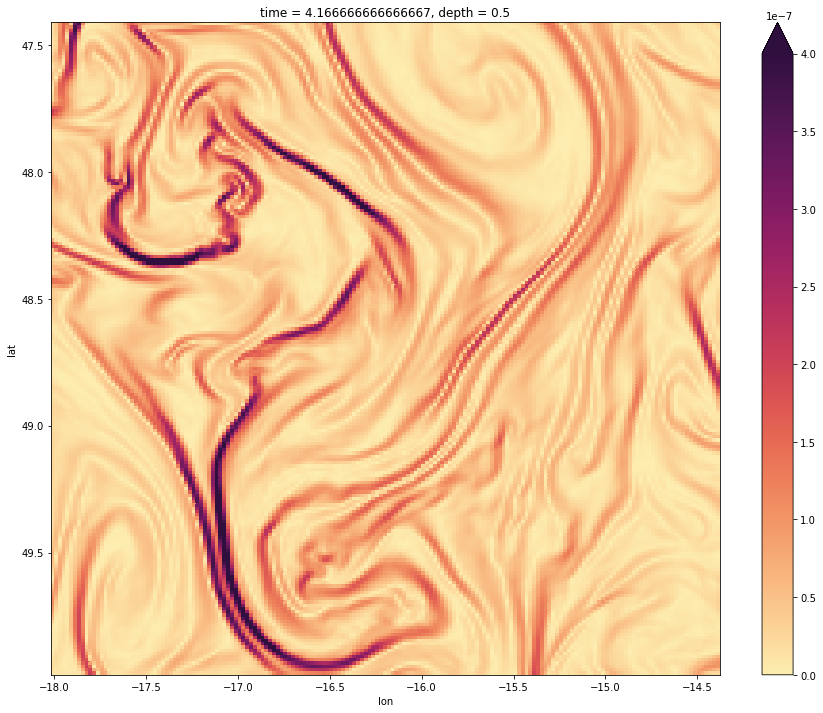

In [11]:
fig = plt.figure(figsize=(15,12))
lateral_buoyancy_gradient.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)

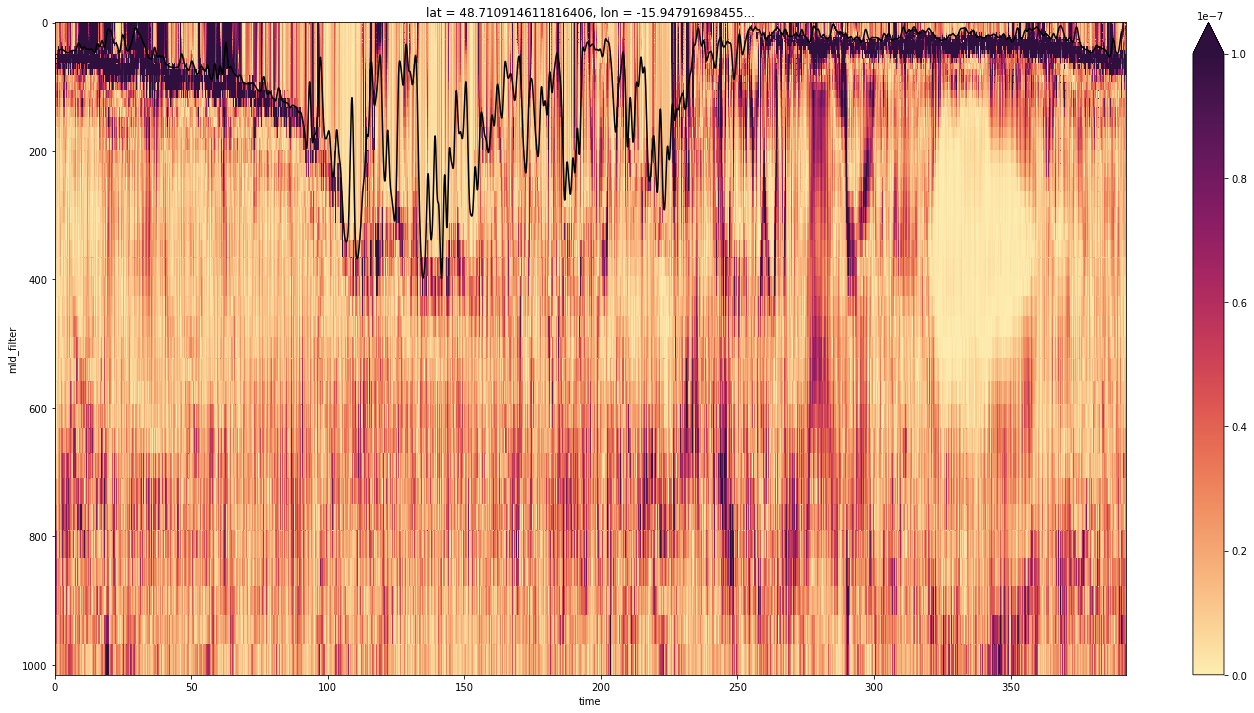

In [12]:
fig = plt.figure(figsize=(24,12))
lateral_buoyancy_gradient.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=1e-7,cmap=cm.matter, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 2.5 PV

In [32]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta_i =  gridx.interp(zeta,'X')
zeta_ij =  gridx.interp(zeta_i,'Y')
zeta_ij

<xarray.DataArray 'mul-9874001ea1550c36bd4525e8fbb68ae1' (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<shape=(201, 177, 9415, 52), dtype=float32, chunksize=(1, 1, 9415, 1)>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...

In [33]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)
print(db_dz)

<xarray.DataArray 'mul-47fd4c658d7e9e58d9f4cf8f4d87f185' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


In [34]:
PV = (f_ij + zeta_ij)*db_dz - (db_dx_ij**2 + db_dy_ij**2)/f_ij
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
PV = PV.chunk(chunks)
PV

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<shape=(201, 177, 9415, 52), dtype=float32, chunksize=(201, 177, 9415, 1)>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...

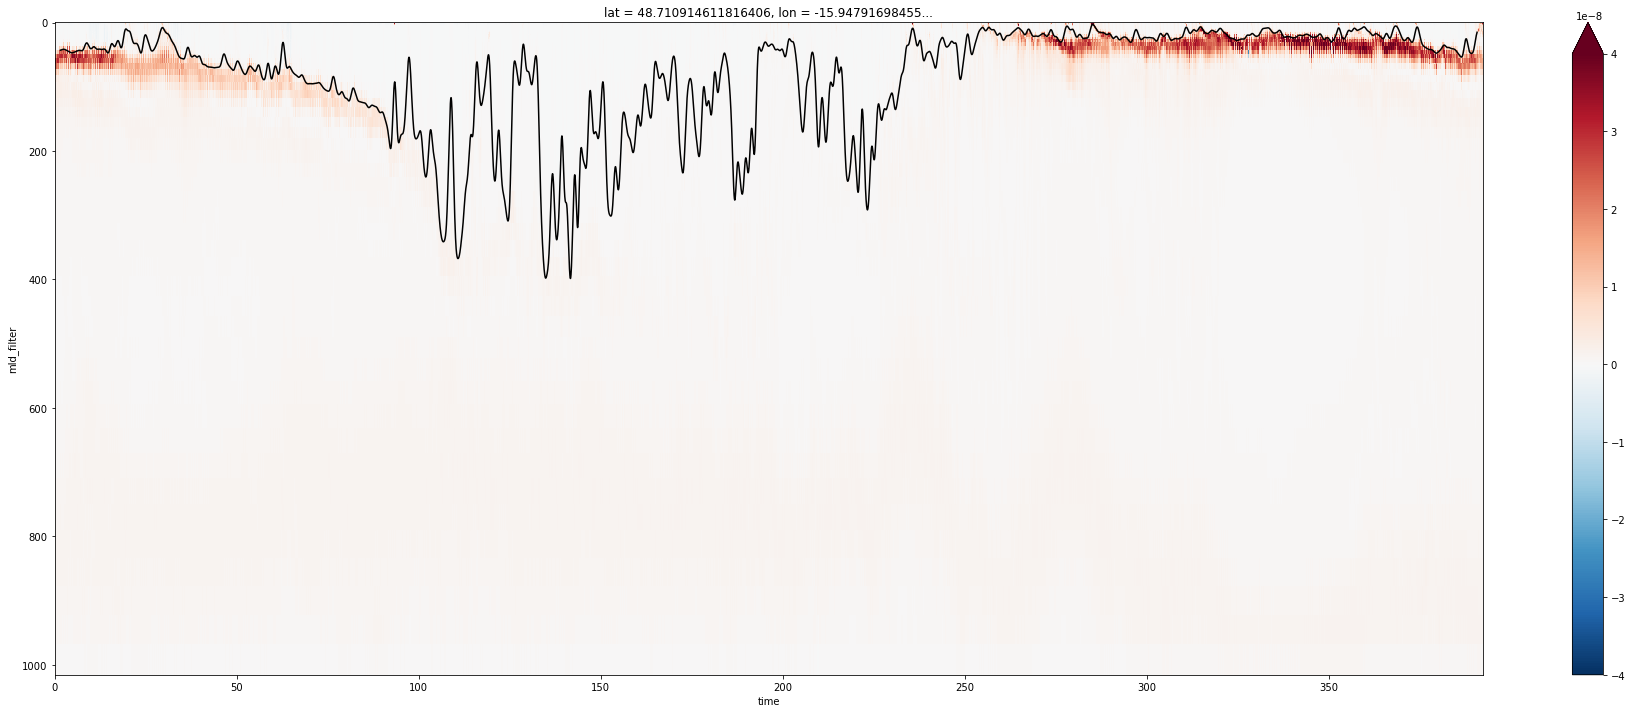

In [35]:
fig = plt.figure(figsize=(32,12))
PV.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-4e-8,vmax=4e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 2.6 Richardson number

In [17]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)
print(db_dz)

<xarray.DataArray 'mul-304308863c5a7ea6013108cda5fbc235' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


In [18]:
dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz_1 = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz = gridx.interp(dU_dz_1,'X')
dU_dz = dU_dz.astype(np.float32)
print(dU_dz)

<xarray.DataArray 'mul-fe615cfebb95debd1e9c3e7b08c0fc99' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


In [19]:
dV_dz_left = -1*gridx.diff(ds.V, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz_1 = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz = gridx.interp(dV_dz_1,'Y')
dV_dz = dV_dz.astype(np.float32)
print(dV_dz)

<xarray.DataArray 'mul-96b7018643cbee47d16cc304d99a3f5e' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


In [20]:
Ri = db_dz/(dU_dz**2 + dV_dz**2)
Ri

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [22]:
store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

In [23]:
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
Ri = Ri.chunk(chunks)
Ri = np.real(Ri).rename('Ri')
Ri = Ri.to_dataset()
print(Ri)
file_out = store_dir_zarr+'/Ri_rechunk.zarr'
%time Ri.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
Data variables:
    Ri       (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 201, 177)>
CPU times: user 22 s, sys: 1.26 s, total: 23.2 s
Wall time: 1min 51s


In [24]:
ds = xr.open_zarr(store_dir_zarr+'Ri_rechunk.zarr')
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    Ri       (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 201, 177)>


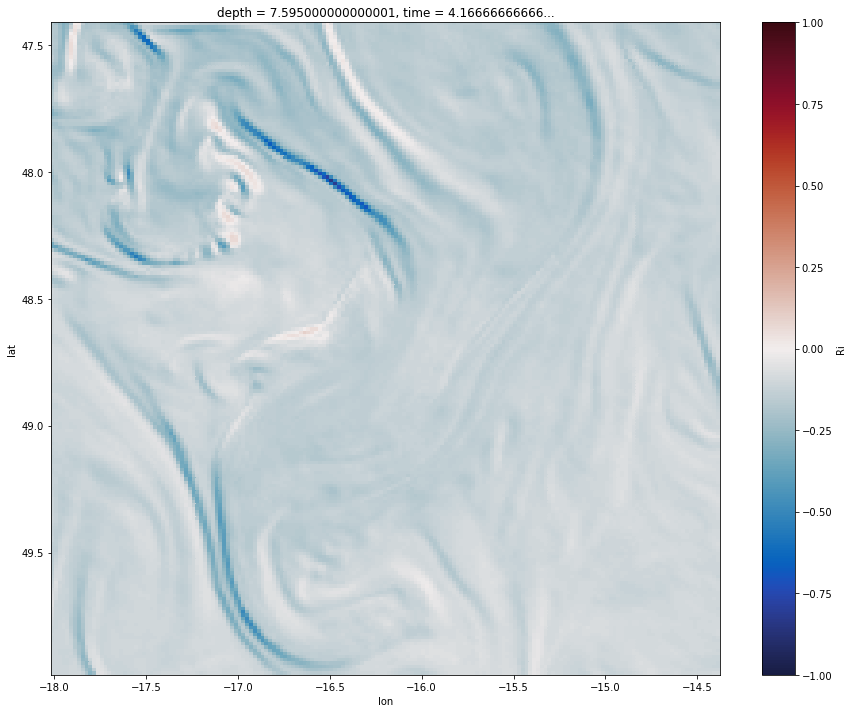

In [41]:
fig = plt.figure(figsize=(15,12))
ds.Ri.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=5).plot(x='lon', y='lat', vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)

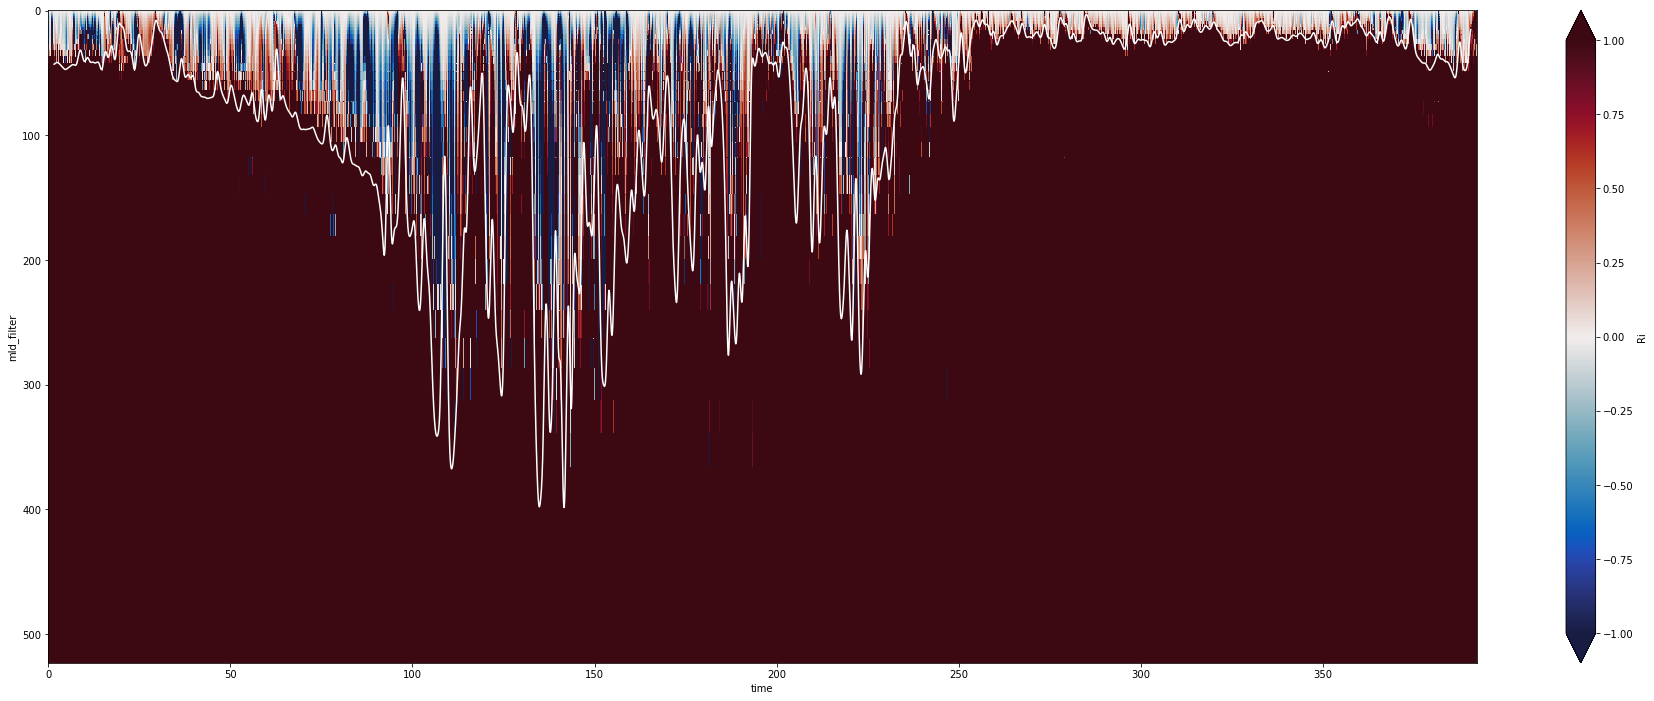

In [43]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

fig = plt.figure(figsize=(32,12))
ds.Ri.isel(lat=100,lon=100,depth=slice(0,40)).plot(x='time', y='depth', cmap=cm.balance, vmin=-1, vmax=1, yincrease=False)
ds_MLD.mld_filter.isel(lat=100,lon=100).plot(x='time',color='white', yincrease=False)

## 2.7 Frontogenesis function

In [14]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')
db_dx_ij

<xarray.DataArray 'mul-511ef0ce500c6282570bc585fe6298f1' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 1)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [15]:
db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')
db_dy_ij

<xarray.DataArray 'mul-113c3b5a17926b515f31c5f9419d529d' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [16]:
du_dx_ij = gridx.diff(ds['U'], 'X')/gridx.interp(ds.dxG, 'Y')
du_dx_ij

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [17]:
dU_dy_1 = gridx.diff(ds['U'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')
du_dy_ij

<xarray.DataArray 'mul-38bfad1e923cac7054151eee7e25fcd2' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [18]:
dV_dx_1 = gridx.diff(ds['V'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')
dv_dx_ij

<xarray.DataArray 'mul-f35c60fcfd873ff60ddf7946f07b138c' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 1)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [19]:
dv_dy_ij = gridx.diff(ds['V'], 'Y')/gridx.interp(ds.dyG, 'X')
dv_dy_ij

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [20]:
Fs = -(du_dx_ij*db_dx_ij*db_dx_ij + dv_dx_ij*db_dx_ij*db_dy_ij + du_dy_ij*db_dx_ij*db_dy_ij + dv_dy_ij*db_dy_ij*db_dy_ij)
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
Fs = Fs.chunk(chunks)
Fs

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [21]:
store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
Fs = Fs.chunk(chunks)
Fs = np.real(Fs).rename('Fs')
Fs = Fs.to_dataset()
print(Fs)
file_out = store_dir_zarr+'/Fs_rechunk.zarr'
%time Fs.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
Data variables:
    Fs       (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 201, 177)>
CPU times: user 36.3 s, sys: 2.6 s, total: 38.9 s
Wall time: 2min 1s


In [22]:
ds = xr.open_zarr(store_dir_zarr+'Fs_rechunk.zarr')
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    Fs       (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 201, 177)>


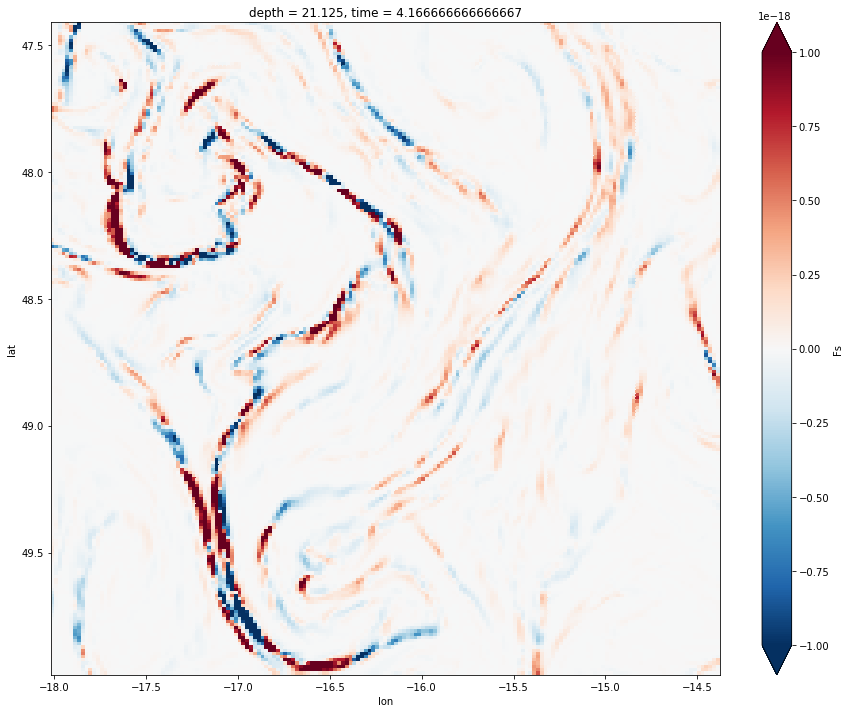

In [25]:
fig = plt.figure(figsize=(15,12))
ds.Fs.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18,cmap='RdBu_r', yincrease=False)

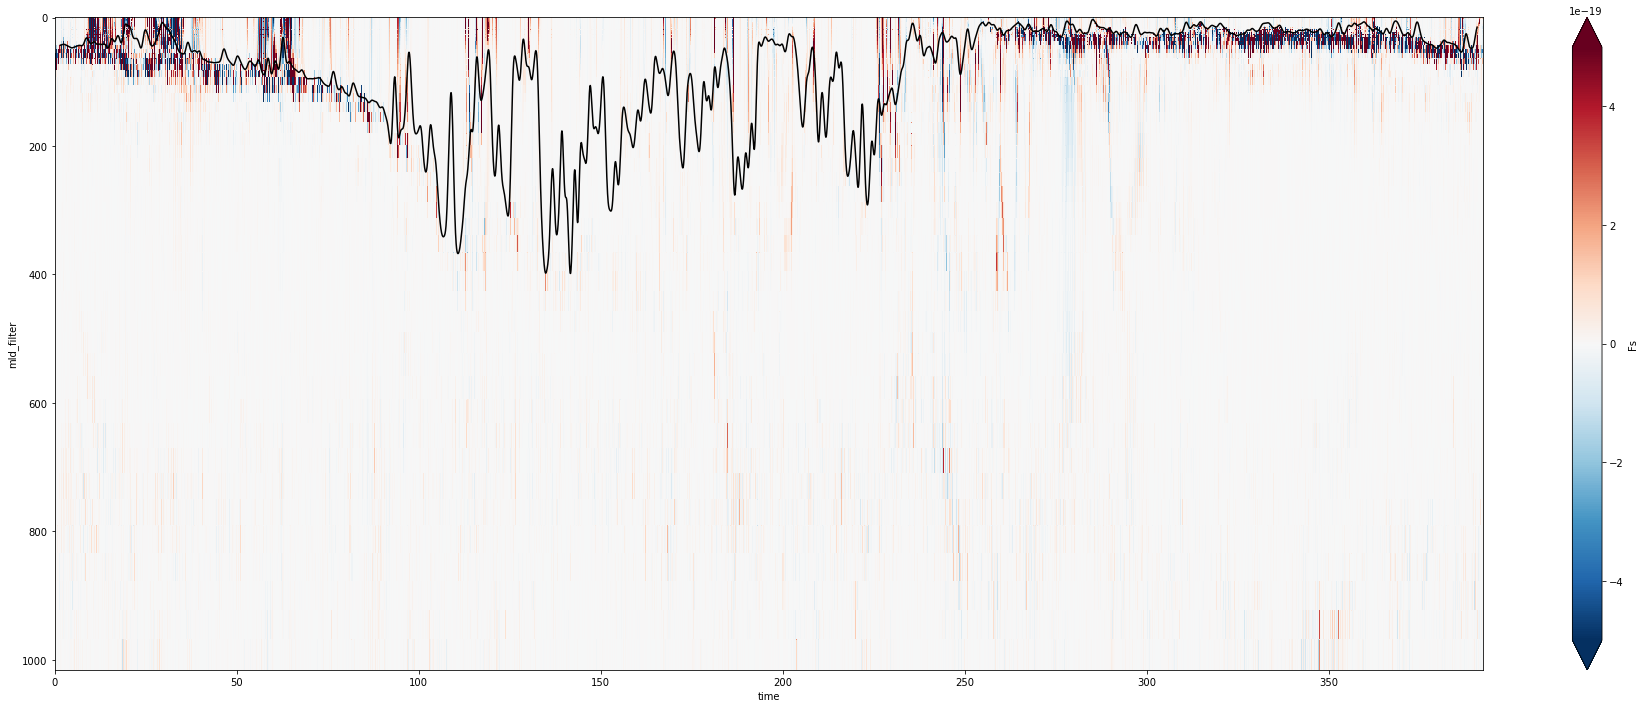

In [31]:
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

fig = plt.figure(figsize=(32,12))
ds.Fs.isel(lat=100,lon=100).plot(x='time', y='depth', vmin=-5e-19, vmax=5e-19, cmap='RdBu_r', yincrease=False)
ds_MLD.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

In [45]:
cluster.scheduler.close()

<Future finished result=None>